# Image classification with Tensorflow, Keras and OpenCV

<p>The aim of this project is to build a neural network that can correctly classify images of 6 different environments, namely <i>mountains</i>, <i>streets</i>, <i>glaciers</i>, <i>buildings</i>, <i>sea</i> and <i>forest</i>. I will therefore use TensorFlow and Keras libraries. Also, to easily read the images in, I will utilize OpenCV library as well.</p>
<p>Since we have multiple classes, it is a multinomial classification problem. The dataset is available <a href="https://datahack.analyticsvidhya.com/">here</a>.</p>

## Loading libraries

To begin with, I will make all the necessary imports.

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt 
import seaborn as sn
from sklearn import decomposition
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import shuffle                      
import cv2
import tensorflow as tf
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Activation , MaxPooling2D, Flatten

Using TensorFlow backend.


In [2]:
import warnings

warnings.simplefilter('ignore')

## Loading and preprocessing data

To make use of our data, I need to give them numerical labels. The dictionary below describes the encoding schema.

In [3]:
class_dict = {'mountain': 0,
              'street' : 1,
              'glacier' : 2,
              'buildings' : 3,
              'sea' : 4,
              'forest' : 5
             }

Now that I specified numerical values for each category, I will write a function to read the files. The data is separated into training and test sets. While reading images, I will make use of the dictionary defined above.

In [4]:
def read_images():

    datasets = ['train', 'test']
    output = []
    
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Now reading: {} set".format(dataset))
        
        for folder in os.listdir(dataset):
            label = class_dict[folder]

            for file in os.listdir(os.path.join(dataset, folder)):
                
                img_path = os.path.join(os.path.join(dataset, folder), file)

                img = cv2.imread(img_path)
                img = cv2.resize(img, (150, 150))

                images.append(img)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

It is possible now to load the data.

In [5]:
(train_images, train_labels), (test_images, test_labels) = read_images()

Now reading: train set
Now reading: test set


To avoid any potential bias related to the order in which the images are located in their folder, I will shuffle the training images and labels.

In [6]:
train_images, train_labels = shuffle(train_images, train_labels)

Now that the data is loaded, I will examine the count of training and test sets and the size of the image (just for check, as they were all reshaped with <i>OpenCV</i>).

In [7]:
print ("Training set size: " + str(train_labels.shape[0]))
print ("Test set size: " + str(test_labels.shape[0]))
print ("Image size: " + str(train_images.shape[1:]))

Training set size: 14034
Test set size: 3000
Image size: (150, 150, 3)


The count, however, does not say much about the number of observations in each category. It will be helpful to check this for the purpose of output analysis.

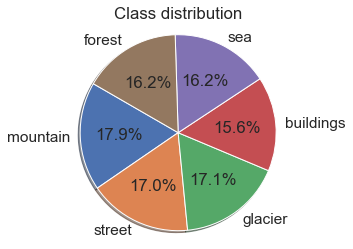

In [8]:
sn.set(font_scale=1.4)

sizes = np.bincount(train_labels)
explode = (0, 0, 0, 0, 0, 0)  
plt.pie(sizes, explode=explode, labels=class_dict.keys(),
autopct='%1.1f%%', shadow=True, startangle=150)
plt.axis('equal')
plt.title('Class distribution')

plt.show()

We see that the classess are quite equally distributed, so there is not risk of building classifier that maximizes its accuracy by assigning dominant class to each observation, which is often the case in highly imbalanced data.

The last step of the preprocessing stage will be to scale the images. Below is the simple function for image scaling.

In [9]:
def image_scaler(images, value):
    return images / value

In [10]:
train_images = image_scaler(train_images, 255.0)
test_images = image_scaler(test_images, 255.0)

## Displaying images

To view what I am dealing with in my work, I will load one random picture. Since I have not set the random seed, each call of this function will generate different image.

In [11]:
class_names = list(class_dict.keys())

def random_image(class_names, images, labels):

    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

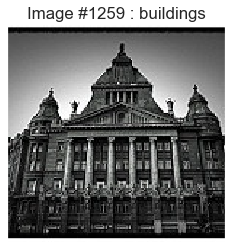

In [12]:
random_image(class_names, train_images, train_labels)

The image above show the example of a building. I will loop this function in another one, trying to display 25 smaller examples, so we can see (hopefully) images from all categories.

In [13]:
def show_examples(class_names, images, labels):

    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Image examples", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

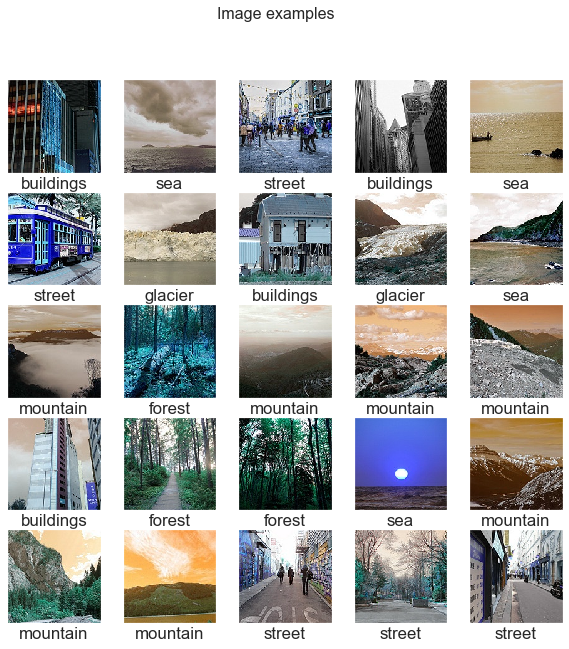

In [14]:
show_examples(class_names, train_images, train_labels)

The image grid above shows the examples from all 6 classes.

## Building neural network

Since the data is ready for use, I will now build a neural network for training the model. They can be much more sophisticated, but, to perform relatively quick presentation of neural network's capabilities, it will not be too complicated. It should, however, still bring some fine results.

In [15]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

After building the model, it needs to be compiled with some parameters as optimizer or the method for computing the loss. In this example, the metric for its performance will be <i>accuracy</i>.

In [16]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

The only thing that left is to start the learning process. The batch size is quite low and the number of epochs also could be higher, but, due to limited computional power, more thorough fit could take really long.

In [19]:
history = model.fit(train_images, train_labels, batch_size=16, epochs=10, validation_split = 0.2)

Train on 11227 samples, validate on 2807 samples
Epoch 1/10
11227/11227 [==============================] - 838s 75ms/sample - loss: 0.8376 - accuracy: 0.6834 - val_loss: 0.7575 - val_accuracy: 0.7168
Epoch 2/10
11227/11227 [==============================] - 734s 65ms/sample - loss: 0.5363 - accuracy: 0.8076 - val_loss: 0.6396 - val_accuracy: 0.7756
Epoch 3/10
11227/11227 [==============================] - 733s 65ms/sample - loss: 0.3169 - accuracy: 0.8900 - val_loss: 0.7252 - val_accuracy: 0.7716
Epoch 4/10
11227/11227 [==============================] - 769s 68ms/sample - loss: 0.1752 - accuracy: 0.9411 - val_loss: 0.8039 - val_accuracy: 0.7763
Epoch 5/10
11227/11227 [==============================] - 733s 65ms/sample - loss: 0.0988 - accuracy: 0.9696 - val_loss: 1.1005 - val_accuracy: 0.7574
Epoch 6/10
11227/11227 [==============================] - 786s 70ms/sample - loss: 0.0753 - accuracy: 0.9770 - val_loss: 1.1814 - val_accuracy: 0.7748
Epoch 7/10
11227/11227 [=====================

Even though this neural network is not that complex as it could be, the fiting process took over 2 hours. When analysing the results, we see continously improving performance on the training set (besides the last epoch) and, after second epoch, compounding predictive efficiency on validation set. This is not the case for the last epoch, indicating that maybe the model could still improve with higher number of epochs.

## Result analysis

Below I will display two plots of the accuracy and loss function values on both training and validation sets.

In [24]:
def plot_accuracy_loss(history):
  
    fig = plt.figure(figsize=(10,5))

    # Accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train & validation")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train & validation")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

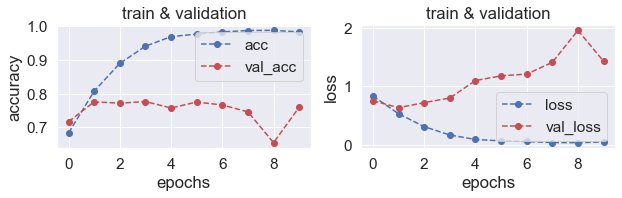

In [25]:
plot_accuracy_loss(history)

There have left a test set with 3000 images. This will tell the actual performance of a model.

In [26]:
test_loss = model.evaluate(test_images, test_labels)

3000/3000 [==============================] - 66s 22ms/sample - loss: 1.4420 - accuracy: 0.7520


The loss function is equal to 1.442, while accuracy is at 0.752. Both scores are really close to the results seen on validation set at the last epoch.

Below is displayed a random example after prediction.

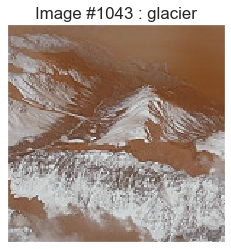

In [28]:
predictions = model.predict(test_images)
pred_labels = np.argmax(predictions, axis = 1)

random_image(class_names, test_images, pred_labels)

Here is the repeated step from data overview, where I displayed 25 random images. Here are those incorrectly classified.

In [30]:
def display_misclassified(class_names, test_images, test_labels, pred_labels):
    """
        Print 25 examples of mislabeled images by the classifier, e.g when test_labels != pred_labels
    """
    check = (test_labels == pred_labels)
    mislabeled_indices = np.where(check == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    title = "Misclassification examples:"
    show_examples(class_names,  mislabeled_images, mislabeled_labels)

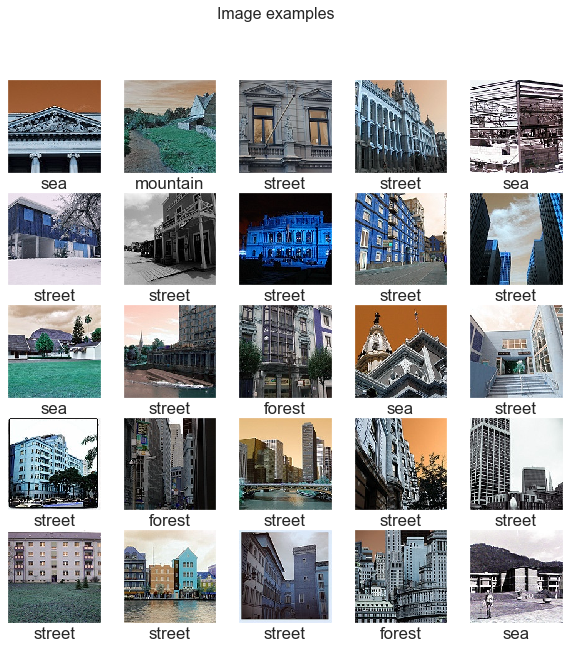

In [31]:
display_misclassified(class_names, test_images, test_labels, pred_labels)

This is not enough to investigate model's efficiency in more detail. To do this, I will display a confusion matrix. It might tell which classes where the most problematic for the neural network.

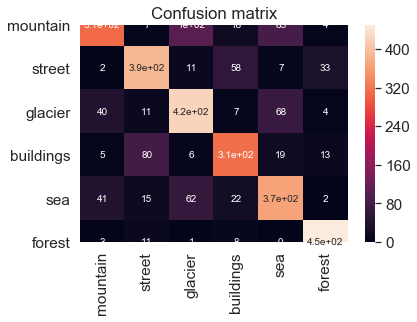

In [32]:
sn.set(font_scale=1.4)

CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

The confusion matrix above indicates two tough pairs. The most misclassified observations are among <i>buildings</i> - <i>street</i> and <i>glacier</i> - <i>sea</i> pairs. These are anthropogenic and natural objects respectively, so there is a hope, that with better resources and more complex model, I can still make improvement.